In [112]:
import pandas as pd
import numpy as np
data = pd.read_csv("./meta/meta.txt", sep="\t", header=None)
types = np.unique(data.iloc[:,-1].values)
print(types)

['background' 'bags' 'door' 'keyboard' 'knocking_door' 'ring' 'speech'
 'tool']


/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [8]:
#data[np.array(data.iloc[:,0], dtype="str") == 't_door_0068_time_stretch_5.wav']

data[data[0] == 'ring_0017.wav'][4]

8675    ring
Name: 4, dtype: object

In [9]:
data.head()

,0,1,2,3,4
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background


In [10]:
colums = ['name', 'x', 'y', 'z', 'type']
data.columns = colums
data.head()

,name,x,y,z,type
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background


In [11]:
data = data.drop(['x', 'y', 'z'], axis=1)
data.head()

,name,type
0,background_0001.wav,background
1,background_0001_time_stretch_0.wav,background
2,background_0001_time_stretch_1.wav,background
3,background_0001_time_stretch_10.wav,background
4,background_0001_time_stretch_11.wav,background


In [34]:
print(data['type'][1125])
print(data['type'][2361])
print(data['type'][2363])
print(len(types))

background
bags
door
8


/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [13]:
for i in range(len(types)):
    print(data[data['type'] == types[i]].count())
    #count.append(data[data[4] == types[i]].count())
    #print(data.groupby('type').sum())

name    1126
type    1126
dtype: int64
name    1236
type    1236
dtype: int64
name    3416
type    3416
dtype: int64
name    1225
type    1225
dtype: int64
name    1656
type    1656
dtype: int64
name    713
type    713
dtype: int64
name    276
type    276
dtype: int64
name    1659
type    1659
dtype: int64


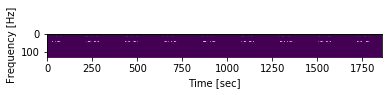

In [4]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('./audio/ring_0115.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks


""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    #print("timebins: ", timebins)
    #print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    #plt.colorbar()

    #plt.xlabel("time (s)")
    #plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight", dpi=300)
    else:
        plt.show()

    plt.clf()
    return ims

for i in range(1):
    filepath = './data_v_7_stc/audio/' + data[0][i]
    #plotstft(filepath, plotpath='data[0][' + str(i) + ']')
    plotstft(filepath, plotpath=str(data[0][i])[:-4])

In [15]:
count = {'background':1125,
         'bags':1236,
         'door':3416,
         'keyboard':1225,
         'knocking_door':1656,
         'ring':713,
         'speech':276,
         'tool':1659}

types = np.unique(data.iloc[:,-1].values)

#for type in types:
#    print(count[type])
data['name'][5]

'background_0001_time_stretch_12.wav'

In [67]:
from pydub import AudioSegment
from tqdm import tqdm

start = 0
sound = []
#for t in tqdm(range(10000)):
for i in range(len(data)):
    filepath = './audio/' + data['name'][i]
    #print(data['name'][i])
    sound.append(AudioSegment.from_wav(filepath))

for type in types:
    if start == 0: 
        print(start)
        print(start+count[type])
        for i in range(start, start+count[type]):
            a = 4
            if (i == start):
                combined_sounds = sound[i]
            else:
                combined_sounds += sound[i]
        start += count[type] + 1
    else:
        print(start)
        print(start+count[type]-1)
        for i in range(start, start+count[type]-1):
            a = 5
            if (i == start):
                combined_sounds = sound[i]
            else:
                combined_sounds += sound[i]
        start += count[type]
    combined_sounds.export('./output/'+type+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


0
1125
1126
2361
2362
5777
5778
7002
7003
8658
8659
9371
9372
9647
9648
11306


In [53]:
start = 0
print(data['type'][9647])
print(data['type'][9648])
print(len(data))
for type in types:
    if start == 0:
        print('start='+str(start))
        print('finish='+str(start+count[type]))
        start += count[type]+1
    else:
        print('start='+str(start))
        print('finish='+str(start+count[type]-1))
        start += count[type]

background
bags
speech
tool
11307
start=0
finish=1125
start=1126
finish=2361
start=2362
finish=5777
start=5778
finish=7002
start=7003
finish=8658
start=8659
finish=9371
start=9372
finish=9647
start=9648
finish=11306


/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [82]:
meta = pd.read_csv("./meta/meta.txt", sep="\t", header=None)

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [73]:
for i in range(16):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/speech.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('speech'+str(i)+'.wav', format="wav")
    

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [74]:
for i in range(15):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/ring.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('ring'+str(i)+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [75]:
for i in range(10):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/background.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('background'+str(i)+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [76]:
for i in range(12):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/bags.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('bags'+str(i)+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [77]:
for i in range(12):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/door.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('door'+str(i)+'.wav', format="wav")

In [78]:
for i in range(12):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/keyboard.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('keyboard'+str(i)+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [79]:
for i in range(9):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/knocking_door.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('knocking_door'+str(i)+'.wav', format="wav")

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [80]:
for i in range(12):
    t1 = 0 + i*600
    t2 = t1 + 600
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    newAudio = AudioSegment.from_wav('./output/tool.wav')
    newAudio = newAudio[t1:t2]
    newAudio.export('tool'+str(i)+'.wav', format="wav")
    

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [81]:
meta = pd.read_csv("./meta/meta.txt", sep="\t", header=None)

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [108]:
!ls -l new

total 4388808
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background0.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background1.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background2.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background3.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background4.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background5.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background6.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background7.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background8.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 background9.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 bags0.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 bags1.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 bags10.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 bags11.wav
-rw-r--r--  1 Pablo  staff  26460044  6 май 13:33 bags2.wav
-rw-r--r--  1 Pablo  sta

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [109]:
!ls -l new | sed -n 's/.*3[0-9]\ \(.*\)/\1/p'

background0.wav
background1.wav
background2.wav
background3.wav
background4.wav
background5.wav
background6.wav
background7.wav
background8.wav
background9.wav
bags0.wav
bags1.wav
bags10.wav
bags11.wav
bags2.wav
bags3.wav
bags4.wav
bags5.wav
bags6.wav
bags7.wav
bags8.wav
bags9.wav
door0.wav
door1.wav
door10.wav
door11.wav
door2.wav
door3.wav
door4.wav
door5.wav
door6.wav
door7.wav
door8.wav
door9.wav
keyboard0.wav
keyboard1.wav
keyboard10.wav
keyboard11.wav
keyboard2.wav
keyboard3.wav
keyboard4.wav
keyboard5.wav
keyboard6.wav
keyboard7.wav
keyboard8.wav
keyboard9.wav
knocking_door0.wav
knocking_door1.wav
knocking_door2.wav
knocking_door3.wav
knocking_door4.wav
knocking_door5.wav
knocking_door6.wav
knocking_door7.wav
knocking_door8.wav
ring0.wav
ring1.wav
ring10.wav
ring11.wav
ring12.wav
ring13.wav
ring14.wav
ring2.wav
ring3.wav
ring4.wav
ring5.wav
ring6.wav
ring7.wav
ring8.wav
ring9.wav
speech0.wav
speech1.wav
speech10.wav
speech11.wav
speech12.wav
speech13.wav
speech14.wav
speech15.wa

/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [130]:
meta = pd.read_csv("./meta/meta.txt", sep="\t", header=None)
meta = meta.drop([1, 2, 3], axis=1)
meta.columns = [0, 1]
new_meta = pd.read_csv("./meta/new.txt", sep=" ", header=None)
data = pd.concat([meta, new_meta])
print(meta.shape)
print(data.shape)

(11307, 2)
(11405, 2)


/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
